<a href="https://colab.research.google.com/github/SauravMaheshkar/medical/blob/main/fMRI/Voxel_to_CLIPvoxel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contributors (in no particular order):
**This list is constantly being updated, feel free to add your contributions**
- Paul Scotti (@humanscotti / @pscotti) (https://github.com/PaulScotti): Project lead
- Aidan Dempster (@veldrovive): Large parts of Voxel-to-CLIP code were modified his work here: https://github.com/Veldrovive/open_clip (in particular check out his networks for future use: https://github.com/Veldrovive/open_clip/blob/main/src/open_clip/model.py)
- Jimmie Goode (@jimgoo) (https://github.com/jimgoo): fixed parts of voxel-to-clip involving l2 norming which greatly improved retrieval evaluations; improved epoch log saving; improved network simplicity without convolutions
- Tanishq Abraham (@ilovescience / @iScienceLuvr) (https://github.com/tmabraham): Overall help with many aspects of project
- Ethan Cohen (@ethan_cohen): Initial explorations of integrating voxels with Dalle2 diffusion prior 
- Nev (@nev): Various explorations including reconstructions via feedforward VQGAN and KNN-based LAION-5B prediction using CLIP embeddings
- Nathalie Verlinde: Projected NSD images to StyleGAN-XL space
- Saurav Maheshkar: helped with ReadMe, .gitignore, random seed
- @Atom_101: Implemented soft loss for CLIP, found better CLIPvoxel performance with larger non-convolutional network, help with feeding CLIP-voxels through to SD

This notebook takes brain voxels and maps them to CLIP-space via contrastive learning.

# Import packages & functions

In [1]:
import os
import sys
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict

from utils import * 
from models import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

seed_everything(seed=0)

device: cuda


In [2]:
# setup multi-gpu Data Distributed Processing (ddp) if available
# if not using ddp, using_ddp should be False and local_rank=0
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import ddp_config
using_ddp,local_rank = ddp_config.ddp_test()
if device=='cuda':
    torch.cuda.set_device(local_rank)

NOT using distributed parallel processing!


In [3]:
# if full_training is True, use large batches and the entire training dataset 
full_training = True
print('full_training:',full_training)

full_training: True


## Which pretrained model are you using for voxel alignment to embedding space? 

In [4]:
img_augmentation = True # do image augmentation?
soft_clip = True # use loss_nce + loss_soft? (seems to improve fwd/bwd retrieval)

model_name = f'clip_image_vitL_aug{img_augmentation}_soft{soft_clip}' # CLIP ViT-L/14 image embeddings
# model_name = 'clip_text_vitL' # CLIP ViT-L/14 text embeddings
# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")
print(f"Image augmentation: {img_augmentation}")

Using model: clip_image_vitL_augTrue_softTrue
Image augmentation: True


In [5]:
if "resnet" in model_name: 
    clip_extractor = Clipper("RN50")
elif "vitL" in model_name: 
    clip_extractor = Clipper("ViT-L/14")
elif "vitB" in model_name: 
    clip_extractor = Clipper("ViT-B/32")
    
if "text" in model_name:     
    image_var = 'trial' 
else:
    image_var = 'images'
print("image_var =", image_var)

# load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
subj01_order = f['subj01'][:]
f.close()
annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
subj01_annots = annots[subj01_order]

ViT-L/14 cuda
image_var = images


# Load data

NSD webdatasets for subjects here:

https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset

In [19]:
if not full_training: 
    num_devices = 1
    num_workers = 1
    print("num_workers",num_workers)
    batch_size = 2
    print("batch_size",batch_size)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..1}.tar"
else:
    num_devices = torch.cuda.device_count()
    print("num_devices",num_devices)
    num_workers = num_devices
    print("num_workers",num_workers)
    batch_size = 300 #1028
    print("batch_size",batch_size)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"

train_data = wds.DataPipeline([wds.ResampledShards(train_url),
                    wds.tarfile_to_samples(),
                    wds.shuffle(500,initial=500),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)
# train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, num_workers=num_workers, shuffle=False)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.SimpleShardList(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

num_devices 1
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 83
validation: num_worker_batches 2


In [7]:
# check that your data loaders are working
for train_i, (voxel, img_input) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape)
    if "text" in model_name:
        emb = clip_extractor.embed_curated_annotations(subj01_annots[img_input])
    else:
        emb = clip_extractor.embed_image(img_input)
    print("emb.shape",emb.shape)
    out_dim = emb.shape[1]
    print("out_dim", out_dim)
    break

idx 0
voxel.shape torch.Size([300, 15724])
emb.shape torch.Size([300, 768])
out_dim 768


# Initialize model

In [8]:
# from models.py
brain_net = BrainNetwork(out_dim) 

if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

# test out that the neural network can run without error:
with torch.cuda.amp.autocast():
    out = brain_net(voxel.to(device))
    if torch.any(torch.isnan(out)):
        raise ValueError("NaN found...")
    print(out.shape)

torch.Size([300, 768])


# Start model training

In [11]:
epoch = 0
num_epochs = 20
initial_learning_rate = 1e-3 #3e-5
optimizer = torch.optim.AdamW(brain_net.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(brain_net.parameters(), lr=initial_learning_rate, momentum=0.95)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, 
                                            total_steps=num_epochs*((24983//batch_size)//num_devices), 
                                            final_div_factor=1000,
                                            last_epoch=-1, pct_start=2/num_epochs)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-8, patience=5) # use lr_scheduler.step(val_loss) 

# loss function
nce = InfoNCE()

train_losses = []; val_losses = []
train_fwd_topk = []; val_fwd_topk = []
train_bwd_topk = []; val_bwd_topk = []
lrs = []
epoch_logs = []

In [12]:
# # # Resume from checkpoint  
# ckpt_path = f'checkpoints/{model_name}_subj01_epoch19.pth'
# checkpoint = torch.load(ckpt_path, map_location=device)
# print(f"Plotting results from {ckpt_path}")
# train_losses=checkpoint['train_losses']
# train_fwd_topk=checkpoint['train_fwd_topk']
# train_bwd_topk=checkpoint['train_bwd_topk']
# val_losses=checkpoint['val_losses']
# val_fwd_topk=checkpoint['val_fwd_topk']
# val_bwd_topk=checkpoint['val_bwd_topk']
# lrs=checkpoint['lrs']
# epoch=checkpoint['epoch']+1
# num_epochs = 40
# brain_net.load_state_dict(checkpoint['model_state_dict'])
# brain_net.eval()

In [13]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")

if full_training:
    print(f"Will be saving model checkpoints to checkpoints/{model_name}_subj01_epoch#.pth")
    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")
else:
    print(f"Warning: not saving model checkpoints")
    
progress_bar = tqdm(range(epoch,num_epochs), ncols=250, disable=(local_rank!=0))
for epoch in progress_bar:
    brain_net.train()
    for train_i, (voxel, img_input) in enumerate(train_dl):
        optimizer.zero_grad()
        
        voxel = voxel.to(device)
        
        with torch.cuda.amp.autocast():
            if image_var=='images': # using images
                if img_augmentation:
                    img_input = img_augment(img_input)
                emb = clip_extractor.embed_image(img_input)
            else: # using text captions of the images 
                emb = clip_extractor.embed_curated_annotations(subj01_annots[img_input])

            emb_ = brain_net(voxel)
            
            # l2 norm before doing cosine similarity
            emb_ = nn.functional.normalize(emb_,dim=-1) 
            
            labels = torch.arange(len(emb)).to(device)
            
            if soft_clip:
                if epoch<10:
                    loss = nce(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
                else:
                    loss = soft_clip_loss(emb_.reshape(len(emb),-1), emb.reshape(len(emb),-1))
            else:
                loss = nce(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
            
            fwd_percent_correct = topk(batchwise_cosine_similarity(emb,emb_),labels,k=1)
            bwd_percent_correct = topk(batchwise_cosine_similarity(emb_,emb),labels,k=1)
            
        loss.backward()
        optimizer.step()
        
        lr_scheduler.step() 
        lrs.append(optimizer.param_groups[0]['lr'])
        
        train_losses.append(loss.item())
        train_fwd_topk.append(fwd_percent_correct.item())
        train_bwd_topk.append(bwd_percent_correct.item())
        
    brain_net.eval()    
    for val_i, (val_voxel, val_img_input) in enumerate(val_dl):
        with torch.no_grad(): 
            val_voxel = val_voxel.to(device)
            
            with torch.cuda.amp.autocast():
                if image_var=='images': # using images
                    val_emb = clip_extractor.embed_image(val_img_input)
                else: # using text captions of the images 
                    val_emb = clip_extractor.embed_curated_annotations(subj01_annots[val_img_input])

                val_emb_ = brain_net(val_voxel)
                
                # l2 norm before doing cosine similarity
                val_emb_ = nn.functional.normalize(val_emb_,dim=-1) 
            
                labels = torch.arange(len(val_emb)).to(device)

                if soft_clip:
                    if epoch<10:
                        val_loss = nce(val_emb_.reshape(len(val_emb),-1),val_emb.reshape(len(val_emb),-1))
                    else:
                        val_loss = soft_clip_loss(val_emb_.reshape(len(val_emb),-1), val_emb.reshape(len(val_emb),-1))
                else:
                    val_loss = nce(val_emb_.reshape(len(val_emb),-1),val_emb.reshape(len(val_emb),-1))

                val_fwd_percent_correct = topk(batchwise_cosine_similarity(val_emb,val_emb_),labels,k=1)
                val_bwd_percent_correct = topk(batchwise_cosine_similarity(val_emb_,val_emb),labels,k=1)
                
            val_losses.append(val_loss.item())
            val_fwd_topk.append(val_fwd_percent_correct.item())
            val_bwd_topk.append(val_bwd_percent_correct.item())
                
    # Save model checkpoint every 5 epochs if full_training==True
    if (epoch+1)%5==0 and full_training:
        print(f'saving checkpoints/{model_name}_subj01_epoch{epoch}.pth...')
        if (using_ddp==False) or (using_ddp==True and local_rank==0):
            state_dict = brain_net.state_dict()
            if using_ddp: # if using DDP, convert DDP state_dict to non-DDP before saving
                for key in list(state_dict.keys()):
                    if 'module.' in key:
                        state_dict[key.replace('module.', '')] = state_dict[key]
                        del state_dict[key]   
            torch.save({
                'epoch': epoch,
                'model_state_dict': state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_fwd_topk': train_fwd_topk,
                'train_bwd_topk': train_bwd_topk,
                'val_fwd_topk': val_fwd_topk,
                'val_bwd_topk': val_bwd_topk,
                'lrs': lrs,
                }, f'checkpoints/{model_name}_subj01_epoch{epoch}.pth')
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
            
    # lr_scheduler.step(val_loss) 
    # lrs.append(optimizer.param_groups[0]['lr'])
    
    # logging the average results across batches for current epoch
    logs = OrderedDict(
        loss=np.mean(train_losses[-(train_i+1):]),
        topk_fwd=np.mean(train_fwd_topk[-(train_i+1):]),
        topk_bwd=np.mean(train_bwd_topk[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
        val_topk_fwd=np.mean(val_fwd_topk[-(val_i+1):]),
        val_topk_bwd=np.mean(val_bwd_topk[-(val_i+1):]),
        lr=lrs[-1],
    )
    progress_bar.set_postfix(**logs)
    epoch_logs.append(logs)
    if full_training:
        pd.DataFrame(epoch_logs).to_csv(f'checkpoints/{model_name}_subj01.epoch-logs.csv')
    
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2022-12-27 11:02:39
num_epochs:20 batch_size:300 lr:0.001
Will be saving model checkpoints to checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch#.pth


 20%|████████████████████▏                                                                                | 4/20 [21:16<1:30:47, 340.46s/it, loss=3.62, lr=0.000291, topk_bwd=0.217, topk_fwd=0.317, val_loss=3.4, val_topk_bwd=0.241, val_topk_fwd=0.281]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch4.pth...


 45%|█████████████████████████████████████████████▉                                                        | 9/20 [46:25<53:50, 293.71s/it, loss=3.05, lr=0.000201, topk_bwd=0.419, topk_fwd=0.554, val_loss=3.25, val_topk_bwd=0.276, val_topk_fwd=0.347]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch9.pth...


 70%|██████████████████████████████████████████████████████████████████████▋                              | 14/20 [1:09:16<27:41, 276.97s/it, loss=1.1, lr=7.47e-5, topk_bwd=0.694, topk_fwd=0.648, val_loss=2.55, val_topk_bwd=0.448, val_topk_fwd=0.425]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch14.pth...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [1:32:06<04:34, 274.11s/it, loss=0.761, lr=2.24e-6, topk_bwd=0.77, topk_fwd=0.735, val_loss=2.34, val_topk_bwd=0.456, val_topk_fwd=0.471]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19.pth...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:36:40<00:00, 290.03s/it, loss=0.772, lr=1.23e-8, topk_bwd=0.766, topk_fwd=0.73, val_loss=2.34, val_topk_bwd=0.453, val_topk_fwd=0.466]

2022-12-27 12:39:19


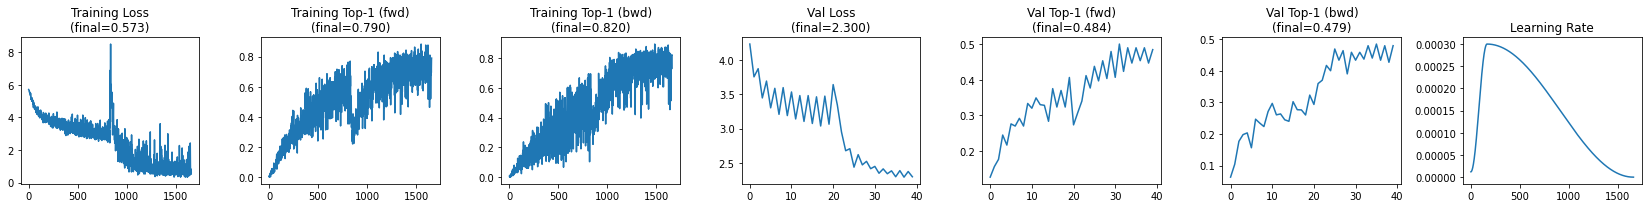

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(23,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]:.3f})")
ax1.plot(train_losses)
ax2.set_title(f"Training Top-1 (fwd)\n(final={train_fwd_topk[-1]:.3f})")
ax2.plot(train_fwd_topk)
ax3.set_title(f"Training Top-1 (bwd)\n(final={train_bwd_topk[-1]:.3f})")
ax3.plot(train_bwd_topk)
ax4.set_title(f"Val Loss\n(final={val_losses[-1]:.3f})")
ax4.plot(val_losses)
ax5.set_title(f"Val Top-1 (fwd)\n(final={val_fwd_topk[-1]:.3f})")
ax5.plot(val_fwd_topk)
ax6.set_title(f"Val Top-1 (bwd)\n(final={val_bwd_topk[-1]:.3f})")
ax6.plot(val_bwd_topk)
ax7.set_title(f"Learning Rate")
ax7.plot(lrs)
fig.tight_layout()
plt.show()

Plotting results from checkpoints/clip_image_vitL_augFalse_softTrue_subj01_epoch9.pth


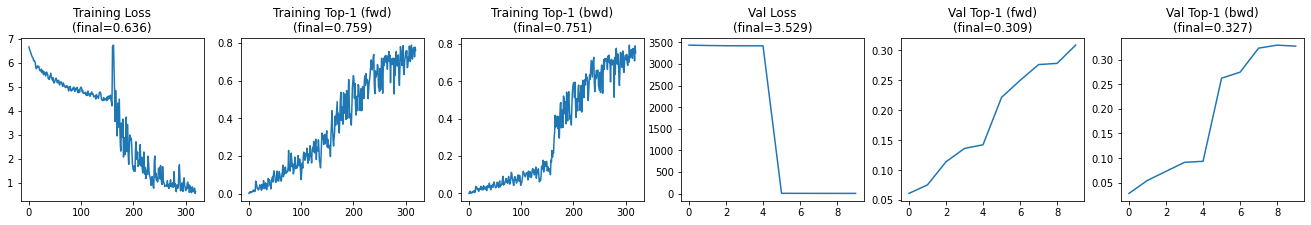

In [10]:
# # # Loading checkpoint  
ckpt_path = 'checkpoints/clip_image_vitL_augFalse_softTrue_subj01_epoch9.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Plotting results from {ckpt_path}")
train_losses=checkpoint['train_losses']
train_fwd_topk=checkpoint['train_fwd_topk']
train_bwd_topk=checkpoint['train_bwd_topk']
val_losses=checkpoint['val_losses']
val_fwd_topk=checkpoint['val_fwd_topk']
val_bwd_topk=checkpoint['val_bwd_topk']
lrs=checkpoint['lrs']

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(23,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]:.3f})")
ax1.plot(train_losses)
ax2.set_title(f"Training Top-1 (fwd)\n(final={train_fwd_topk[-1]:.3f})")
ax2.plot(train_fwd_topk)
ax3.set_title(f"Training Top-1 (bwd)\n(final={train_bwd_topk[-1]:.3f})")
ax3.plot(train_bwd_topk)
ax4.set_title(f"Val Loss\n(final={val_losses[-1]:.3f})")
ax4.plot(val_losses)
ax5.set_title(f"Val Top-1 (fwd)\n(final={val_fwd_topk[-1]:.3f})")
ax5.plot(val_fwd_topk)
ax6.set_title(f"Val Top-1 (bwd)\n(final={val_bwd_topk[-1]:.3f})")
ax6.plot(val_bwd_topk)
ax7.set_title(f"Learning Rate")
ax7.plot(lrs)
fig.tight_layout()
plt.show()

## Evaluation: Top-K Image Retrieval
Restart kernel and run all above cells excluding "Start model training"

In [20]:
num_worker_batches = 10
eval_batch_size = 300
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", "images", "trial"),
                    wds.batched(eval_batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

fwd percent_correct tensor(0.4227, device='cuda:0')
bwd percent_correct tensor(0.4223, device='cuda:0')


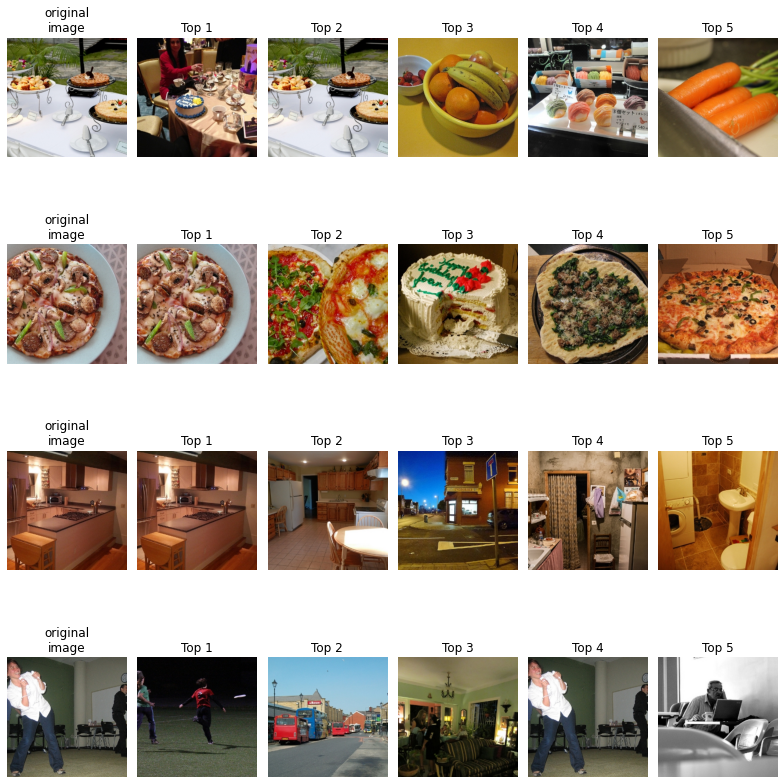

In [21]:
# CLIP Image evaluation
ckpt_path = 'checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19.pth'
# checkpoint = torch.load(ckpt_path, map_location=device)
# brain_net.load_state_dict(checkpoint['model_state_dict'])
brain_net.eval()

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)

            if "image" in ckpt_path: # using images
                emb0 = clip_extractor.embed_image(img)
            else:
                emb0 = clip_extractor.embed_curated_annotations(subj01_annots[trial])

            emb_0 = nn.functional.normalize(brain_net(voxel),dim=-1)  # brain embeddings

            labels = torch.arange(len(emb0)).to(device)
            similarities0_bwd = batchwise_cosine_similarity(emb0,emb_0)  # clip, brain
            similarities0_fwd = batchwise_cosine_similarity(emb_0,emb0)  # brain, clip

            if val_i==0:
                cnt=1
                percent_correct_fwd = topk(similarities0_fwd, labels,k=1)
                percent_correct_bwd = topk(similarities0_bwd, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += topk(similarities0_fwd, labels,k=1)
                percent_correct_bwd += topk(similarities0_bwd, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

# plot results from one batch
similarities0_fwd = np.array(similarities0_fwd.detach().cpu())
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(similarities0_fwd[trial]))[attempt]
        ax[trial, attempt+1].imshow(torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

fwd percent_correct tensor(0.1587, device='cuda:0')
bwd percent_correct tensor(0.1540, device='cuda:0')


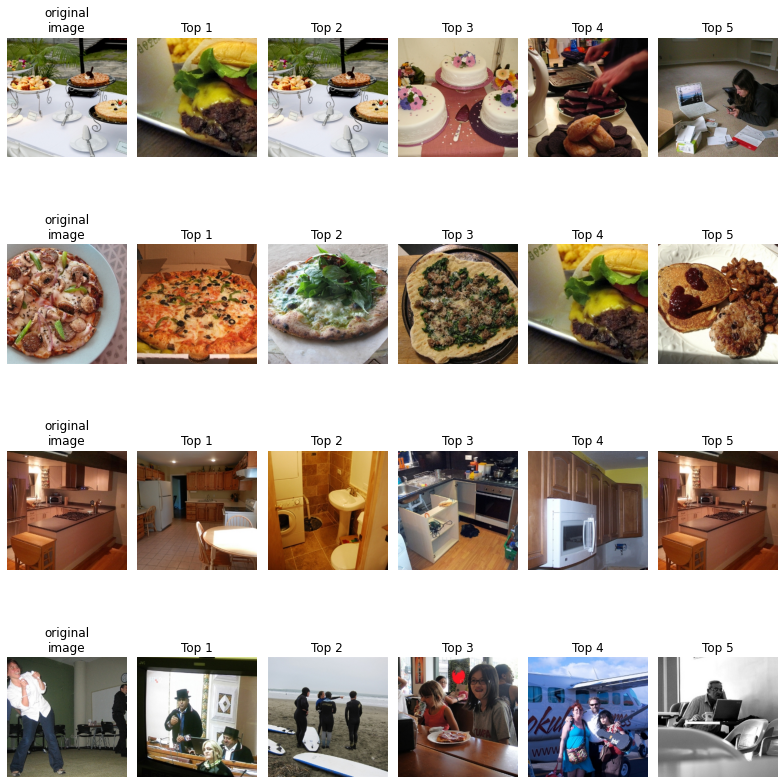

In [27]:
# CLIP Text evaluation
ckpt_path = 'checkpoints/clip_text_vitB_conv_subj01_epoch25.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
brain_net.load_state_dict(checkpoint['model_state_dict'])
brain_net.eval()

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)

            if "image" in ckpt_path: # using images
                emb0 = clip_extractor.embed_image(img)
            else:
                emb0 = clip_extractor.embed_curated_annotations(subj01_annots[trial])

            emb_0 = nn.functional.normalize(brain_net(voxel),dim=-1)  # brain embeddings

            labels = torch.arange(len(emb0)).to(device)
            similarities0_bwd = batchwise_cosine_similarity(emb0,emb_0)  # clip, brain
            similarities0_fwd = batchwise_cosine_similarity(emb_0,emb0)  # brain, clip

            if val_i==0:
                cnt=1
                percent_correct_fwd = topk(similarities0_fwd, labels,k=1)
                percent_correct_bwd = topk(similarities0_bwd, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += topk(similarities0_fwd, labels,k=1)
                percent_correct_bwd += topk(similarities0_bwd, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

# plot results from one batch
similarities0_fwd = np.array(similarities0_fwd.detach().cpu())
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(similarities0_fwd[trial]))[attempt]
        ax[trial, attempt+1].imshow(torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

fwd percent_correct tensor(0.4590, device='cuda:0')
bwd percent_correct tensor(0.4397, device='cuda:0')


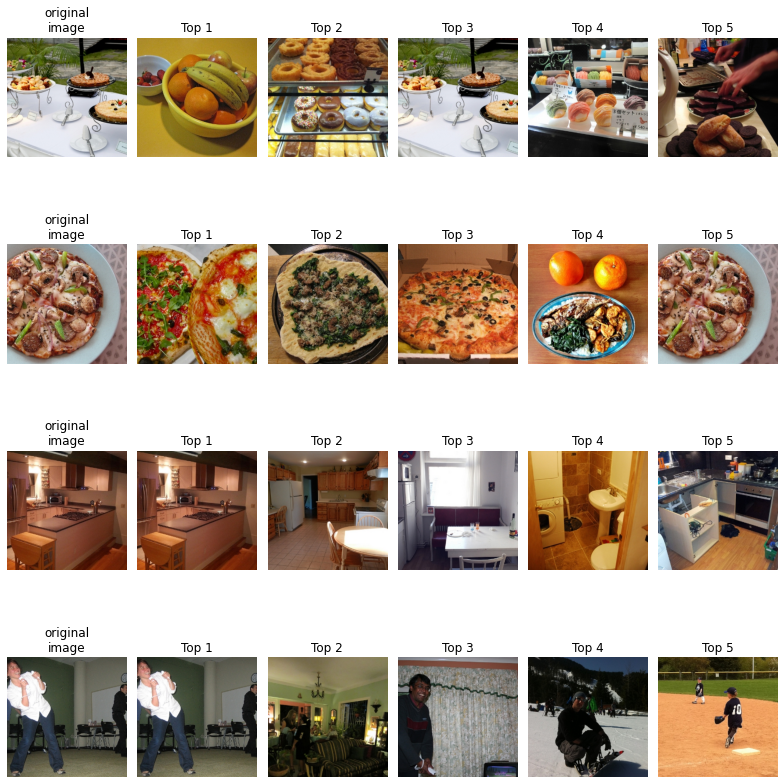

In [22]:
# CLIP Image+Text (Combined) evaluation

# image
ckpt_path = 'checkpoints/clip_image_vitL_augFalse_softTrue_subj01_epoch9.pth'
checkpoint = torch.load(ckpt_path, map_location=device)

brain_net.load_state_dict(checkpoint['model_state_dict'])
brain_net.eval()

# text
ckpt_path2 = 'checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch14.pth'
checkpoint2 = torch.load(ckpt_path2, map_location=device)

brain_net2 = BrainNetwork(out_dim).to(device)
brain_net2.load_state_dict(checkpoint2['model_state_dict'])
brain_net2.eval()

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            
            emb0 = clip_extractor.embed_image(img)
            emb1 = clip_extractor.embed_curated_annotations(subj01_annots[trial])
            
            emb_0 = nn.functional.normalize(brain_net(voxel),dim=-1)  # brain embeddings
            emb_1 = nn.functional.normalize(brain_net2(voxel),dim=-1)  # brain embeddings
            
            # combine the models, can try weighted average
            embC = emb0 #(emb0 + emb1)/2
            emb_C = (emb_0 + emb_1)/2 

            labels = torch.arange(len(emb0)).to(device)
            
            similarities_combined_bwd = batchwise_cosine_similarity(embC,emb_C)  # clip, brain
            similarities_combined_fwd = batchwise_cosine_similarity(emb_C,embC)  # brain, clip

            if val_i==0:
                cnt=1
                percent_correct_fwd = topk(similarities_combined_fwd, labels,k=1)
                percent_correct_bwd = topk(similarities_combined_bwd, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += topk(similarities_combined_fwd, labels,k=1)
                percent_correct_bwd += topk(similarities_combined_bwd, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

# plot results from one batch
similarities_combined_fwd = np.array(similarities_combined_fwd.detach().cpu())
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(similarities_combined_fwd[trial]))[attempt]
        ax[trial, attempt+1].imshow(torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()